In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean as cmo
import seaborn as sb
import cftime

def mask_composite(ds, var, start_year=0, min_lat=-90, max_lat=90, min_lon=-180, max_lon=360):
    X = np.meshgrid(ds.x.data,ds.y.data)
    mask = xr.DataArray(np.sqrt(X[0]**2 + X[1]**2) <= 10, dims=['x', 'y'])
    
    idx_region = (ds.snap_time.dt.year > start_year) & (ds.snap_lat >= min_lat) & (ds.snap_lat <= max_lat) & \
    (ds.snap_lon >= min_lon) & (ds.snap_lon <= max_lon)
    
    test = ds[var][idx_region,:,:]
    test = xr.where(abs(test)>1e10, np.nan, test)
    test = xr.where(test==0, np.nan, test)

    out_masked = xr.where(mask, test, np.nan)
    return out_masked

def create_date_index(ds, middle_date):
    date_low = (middle_date - 15)%365 + 1
    date_high = (middle_date + 15)%365 + 1
    
    if date_high > date_low: 
            idx = ((ds.time.dt.dayofyear >= date_low) & (ds.time.dt.dayofyear <= date_high))
    if date_high < date_low:
            idx = ((ds.time.dt.dayofyear >= date_low) | (ds.time.dt.dayofyear <= date_high))
            
    return idx

def composites_doy(ds, var): 
    test = ds[f'snap_{var}_anom']
    test = xr.where(abs(test)>1e10, np.nan, test)
    test = xr.where(test==0, np.nan, test)

    X = np.meshgrid(ds.x.data,ds.y.data)
    mask = xr.DataArray(np.sqrt(X[0]**2 + X[1]**2) <= 10, dims=['x', 'y'])
    masked_var = xr.where(mask, test, np.nan)

    # subsample for periods that we have ocean output (daily, timestamp is 12:00:00)
    ds.snap_time.dt.hour == 12
    time = ds.snap_time[ds.snap_time.dt.hour == 12]
    snap = ds.snapshot[ds.snap_time.dt.hour == 12]

    flux = masked_var[:,:,ds.snap_time.dt.hour == 12]

    # create a dataset to group snapshots by day of year
    ds_masked = xr.Dataset(
        data_vars=dict(
            flux=(["x", "y", "snapshot"], flux.data),
            time=(["snapshot"], time.data),
        ),
        coords=dict(
            x=ds.x.data,
            y=ds.y.data,
            snapshot=snap.data,
        ),
        attrs=dict(description=f"{var} snapshots"),
    )

    flux_avg_tot = flux.mean(dim="snapshot")
    flux_avg_doy = ds_masked.flux.groupby(time.dt.dayofyear).mean(skipna=True)
    
    return ds_masked

In [2]:
models = ["CM4", "ESM4"]

fpath_hfds = {"CM4": "/work/Katherine.Turner/tempest-extremes/odiv-251/comp_hfds",
        "ESM4": "/work/Katherine.Turner/tempest-extremes/ESM4/hfds"}

fpath_dic = {"CM4": "/work/Katherine.Turner/tempest-extremes/odiv-251/comp_f_dic",
        "ESM4": "/work/Katherine.Turner/tempest-extremes/ESM4/dic_stf_gas"}

## 0. Mean storm flux composites for heat and carbon

In [34]:
m = 'CM4'
nyr = 95
ds_hfds = xr.open_dataset(f"{fpath_hfds[m]}/comp_hfds_anom.nc", use_cftime=True)
ds_dic = xr.open_dataset(f"{fpath_dic[m]}/comp_dic_stf_gas_anom.nc", use_cftime=True)
    
hfds_masked = mask_composite(ds_hfds, "snap_hfds_anom")
dic_masked = mask_composite(ds_dic, "snap_dic_stf_gas_anom")

In [23]:
(dx**2 * dic_masked.sum(dim={'x','y'})).mean() * 12.011 * 60**2 * 24

<xarray.DataArray ()>
array(-2.05763913e+10)

In [35]:
(dx**2 * dic_masked.sum(dim={'x','y'})).sum() * 12.011 * 60**2 * 24 / (95*4)

<xarray.DataArray ()>
array(-4.69468794e+13)

In [36]:
(dx**2 * hfds_masked.sum(dim={'x','y'})).sum() * 60**2 * 24 /(95*4)

<xarray.DataArray ()>
array(-6.64558192e+21)

In [38]:
(dx**2 * (hfds_masked/hfds_masked)).sum(dim={'x', 'y'}).mean()

<xarray.DataArray ()>
array(3.0197995e+12, dtype=float32)

In [39]:
3.0197995e+12/(1e3)**2

3019799.5

In [6]:
dx = 0.5 * 111e3
print(1/nyr * (dx**2 * (hfds_masked.sum())).data)
print(1/nyr * (dx**2 * 12.011 * 60**2 * 24 * dic_masked.sum()).data)

-3.4053938171136e+17
-126946.10519716807


In [ ]:
fig, axs = plt.subplots(figsize=(6,5.5), ncols=2, nrows=2)
axs=axs.flatten()

for i, m in enumerate(models):
    ds_hfds = xr.open_dataset(f"{fpath_hfds[m]}/comp_hfds_anom.nc", use_cftime=True)
    ds_dic = xr.open_dataset(f"{fpath_dic[m]}/comp_dic_stf_gas_anom.nc", use_cftime=True)
    
    hfds_masked = mask_composite(ds_hfds, "snap_hfds_anom")
    dic_masked = mask_composite(ds_dic, "snap_dic_stf_gas_anom")
    
    hfds_masked.mean(dim="snapshot").plot(ax=axs[i], y='y', cmap="RdBu_r",
                                     vmin=-45, vmax=45, extend="neither",
                                      cbar_kwargs = {'fraction': 0.03,
                                                    'aspect': 30,
                                                    'shrink': 0.7,
                                                    'label':'W m$^{-2}$'})

    (1e3* 60**2 * 24 * dic_masked.mean(dim="snapshot")).plot(ax=axs[i+2], y='y', 
                                     cmap=sb.diverging_palette(300, 145, s=60, as_cmap=True),
                                     vmin=-2, vmax=2, extend="neither",
                                     cbar_kwargs = {'fraction': 0.03,
                                                    'aspect': 30,
                                                    'shrink': 0.7,
                                                    'label':'mmol C m$^{-2}$ day$^{-1}$'})
    
titles = ["(a) CM4 storm heat flux", 
          "(b) ESM4 storm heat flux",
          "(c) CM4 storm CO$_2$ flux",
          "(d) ESM4 storm CO$_2$ flux"]

for i in np.arange(4):
    axs[i].set_ylabel('$^{\circ}$ N from storm center', fontsize=9)
    axs[i].set_xlabel('$^{\circ}$ E from storm center', fontsize=9)
    axs[i].set_title(titles[i])
    axs[i].set_aspect(1)
    
plt.tight_layout()

plt.savefig("/work/Katherine.Turner/CM4_storms/analysis_figures/GFDL_storm_comp_flux_anom.png",
           format="png",
           dpi=100,
           bbox_inches="tight")
plt.savefig("/home/Katherine.Turner/Figures/tempest-extremes/composite_fluxes/GFDL_storm_comp_flux_anom.png",
           format="png",
           dpi=100,
           bbox_inches="tight")
plt.savefig("/home/Katherine.Turner/GFDL_storm_comp_flux_anom.eps",
           format="eps")

## 1. Integrated heat and carbon exchange -- 'storm climatology'

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


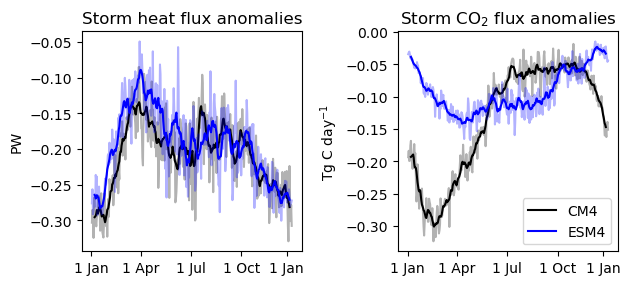

In [16]:
nyears = {"CM4":95, "ESM4":100}
l_color = {"CM4":'k', "ESM4":'b'}

dx = 0.5 * 111e3

fig, axs = plt.subplots(nrows=1, ncols=2)

for m in models:
    ds = xr.open_dataset(f"{fpath_hfds[m]}/comp_hfds_anom.nc", use_cftime=True)
    ds_out = composites_doy(ds, 'hfds')
    x = (1/nyears[m] * ds_out.flux.groupby(ds_out.time.dt.dayofyear).sum().sum(dim={'x','y'})) * dx**2
    (1e-15*x).plot(ax=axs[0], alpha=0.3, color=l_color[m])
    (1e-15*x).rolling(dayofyear=10, center=True).mean().plot(ax=axs[0], color=l_color[m])
    
    ds = xr.open_dataset(f"{fpath_dic[m]}/comp_dic_stf_gas_anom.nc", use_cftime=True)
    ds_out = composites_doy(ds, 'dic_stf_gas')
    y = (1/nyears[m] * ds_out.flux.groupby(ds_out.time.dt.dayofyear).sum().sum(dim={'x','y'})) * dx**2 * 60**2 * 24
    (12.011e-12*y).plot(ax=axs[1], alpha=0.3, color=l_color[m])
    (12.011e-12*y).rolling(dayofyear=10, center=True).mean().plot(ax=axs[1], color=l_color[m],
                                                                 label=m)

for i in range(2):
    axs[i].set_box_aspect(1)
    axs[i].set_xticks([0, 90, 181, 273, 356])
    axs[i].set_xticklabels(["1 Jan", "1 Apr", "1 Jul", "1 Oct", "1 Jan"])
    axs[i].set_xlabel('')
    
axs[0].set_title("Storm heat flux anomalies")
axs[1].set_title("Storm CO$_2$ flux anomalies")
axs[0].set_ylabel("PW")
axs[1].set_ylabel(r"Tg C day$^{-1}$")
axs[1].legend()
    
plt.tight_layout()

plt.savefig("/work/Katherine.Turner/CM4_storms/analysis_figures/GFDL_storm_flux_doy.png",
           format="png",
           dpi=100,
           bbox_inches="tight")
plt.savefig("/home/Katherine.Turner/Figures/tempest-extremes/composite_fluxes/GFDL_storm_flux_doy.png",
           format="png",
           dpi=100,
           bbox_inches="tight")
plt.savefig("/home/Katherine.Turner/GFDL_storm_flux_doy.eps",
           format="eps")

## 2. Composites of heat and carbon fluxes during periods of weak and strong storm fluxes

In [23]:
m = 'CM4'

ds = xr.open_dataset(f"{fpath_hfds[m]}/comp_hfds_anom.nc", use_cftime=True)
ds_out = composites_doy(ds, 'hfds')
x = (1/nyears[m] * ds_out.flux.groupby(ds_out.time.dt.dayofyear).sum().sum(dim={'x','y'})) * dx**2
    
ds = xr.open_dataset(f"{fpath_dic[m]}/comp_dic_stf_gas_anom.nc", use_cftime=True)
ds_out = composites_doy(ds, 'dic_stf_gas')
y = (1/nyears[m] * ds_out.flux.groupby(ds_out.time.dt.dayofyear).sum().sum(dim={'x','y'})) * dx**2 * 60**2 * 24

print(np.argmax(x.data))
print(np.argmin(x.data))

print(np.argmax(y.data))
print(np.argmin(y.data))

86
358
301
46


In [25]:
dates = {'CM4_hfds_low':358,
         'CM4_hfds_high':86,
         'CM4_dic_stf_gas_low':46,
         'CM4_dic_stf_gas_high':301,
         'ESM4_hfds_low':345,
         'ESM4_hfds_high':87,
         'ESM4_dic_stf_gas_low':113,
         'ESM4_dic_stf_gas_high':341}

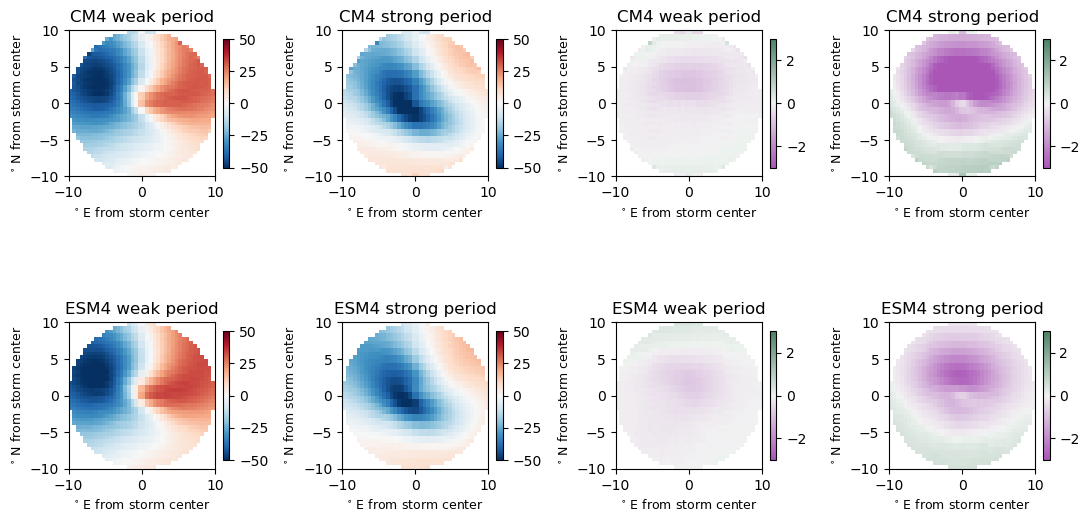

In [66]:
fig,axs = plt.subplots(figsize=(11, 6), nrows=2, ncols=4)
axs=axs.flatten()

for i,m in enumerate(models):
    ds = xr.open_dataset(f"{fpath_hfds[m]}/comp_hfds_anom.nc", use_cftime=True)
    heat_out = composites_doy(ds, 'hfds')

    ds = xr.open_dataset(f"{fpath_dic[m]}/comp_dic_stf_gas_anom.nc", use_cftime=True)
    dic_out = composites_doy(ds, 'dic_stf_gas')
    
    for j,v in enumerate(['high', 'low']):
    
        mid_date_heat = dates[f'{m}_hfds_{v}']
        idx = create_date_index(heat_out, mid_date_heat)
    
        heat_out.flux[:,:,idx].mean(dim='snapshot').plot(ax=axs[4*i+j], y='y',
                                                         vmin=-50, vmax=50,
                                                         cmap='RdBu_r',
                                                         cbar_kwargs={'label':'',"aspect":20, "shrink":0.8, "fraction":0.04,},
                                                         extend="neither")
        axs[4*i+j]
        
        mid_date_dic = dates[f'{m}_dic_stf_gas_{v}']
        idx = create_date_index(dic_out, mid_date_dic)

        (24*60**2*1e3*dic_out.flux[:,:,idx].mean(dim='snapshot')).plot(ax=axs[4*i+j+2], y='y',
                                                                       vmin=-3, vmax=3,
                                                                       cmap = sb.diverging_palette(300, 145, s=60, as_cmap=True),
                                                                       cbar_kwargs={'label':'',"aspect":20, "shrink":0.8, "fraction":0.04,},
                                                                       extend="neither")
titles = ['CM4 weak period', 'CM4 strong period', 'CM4 weak period', 'CM4 strong period',
         'ESM4 weak period', 'ESM4 strong period', 'ESM4 weak period', 'ESM4 strong period']
for ii in range(8):
    axs[ii].set_title(titles[ii])
    axs[ii].set_box_aspect(1)
    axs[ii].set_ylabel('$^{\circ}$ N from storm center', fontsize=9)
    axs[ii].set_xlabel('$^{\circ}$ E from storm center', fontsize=9)
    
plt.tight_layout()

plt.savefig("/work/Katherine.Turner/CM4_storms/analysis_figures/GFDL_storm_flux_doy_panels.png",
           format="png",
           dpi=100,
           bbox_inches="tight")
plt.savefig("/home/Katherine.Turner/Figures/tempest-extremes/composite_fluxes/GFDL_storm_flux_doy_panels.png",
           format="png",
           dpi=100,
           bbox_inches="tight")
plt.savefig("/home/Katherine.Turner/GFDL_storm_flux_doy_panels.eps",
           format="eps")

## 3. Correlations between storm heat and carbon exchange and climatological fluxes

In [67]:
def integrated_storm_fluxes(ds_doy, nyears):
    dx = 0.5 * 111e3
    x = (1/nyears * ds_doy.flux.groupby(ds_doy.time.dt.dayofyear).sum().sum(dim={'x','y'})) * dx**2
    return x

In [68]:
ds = xr.open_dataset(f"{fpath_hfds['CM4']}/comp_hfds_anom.nc", use_cftime=True)
ds_interim = composites_doy(ds, 'hfds')
CM4_stormheat = integrated_storm_fluxes(ds_interim, 95)

ds = xr.open_dataset(f"{fpath_dic['CM4']}/comp_dic_stf_gas_anom.nc", use_cftime=True)
ds_interim = composites_doy(ds, 'dic_stf_gas')
CM4_stormcarb = integrated_storm_fluxes(ds_interim, 95)

ds = xr.open_dataset(f"{fpath_hfds['ESM4']}/comp_hfds_anom.nc", use_cftime=True)
ds_interim = composites_doy(ds, 'hfds')
ESM4_stormheat = integrated_storm_fluxes(ds_interim, 100)

ds = xr.open_dataset(f"{fpath_dic['ESM4']}/comp_dic_stf_gas_anom.nc", use_cftime=True)
ds_interim = composites_doy(ds, 'dic_stf_gas')
ESM4_stormcarb = integrated_storm_fluxes(ds_interim, 100)

In [74]:
path_clim = {"CM4_hfds": "/work/Katherine.Turner/tempest-extremes/odiv-251/comp_hfds/clim_hfds.nc",
        "ESM4_hfds": "/work/Katherine.Turner/tempest-extremes/ESM4/hfds/clim_hfds.nc",
        "CM4_dic_stf_gas": "/work/Katherine.Turner/tempest-extremes/odiv-251/comp_dic_stf_gas/clim_dic_stf_gas.nc",
        "ESM4_dic_stf_gas": "/work/Katherine.Turner/tempest-extremes/ESM4/dic_stf_gas/clim_dic_stf_gas.nc"}

archive = {"CM4": "/archive/Katherine.Turner/xanadu_mom6_20220703/CM4_piControl_C_restartyear148/gfdl.ncrc5-intel22-prod-openmp/pp",
           "ESM4": "/archive/Katherine.Turner/fre/FMS2021.02_mom6_ESM4_v1.0.3/ESM4_piControl_D/gfdl.ncrc5-intel23-prod-openmp/pp"}

In [75]:
ds_CM4 = xr.open_dataset(f'/work/Katherine.Turner/CM4_storms/code/response/clim_CM4_hfds.nc', use_cftime=True)
ds_ESM4 = xr.open_dataset(f'/work/Katherine.Turner/CM4_storms/code/response/clim_ESM4_hfds.nc', use_cftime=True)
    
grid = xr.open_dataset(f"{archive['CM4']}/ocean_daily_1x1deg/ocean_daily_1x1deg.static.nc")
area = grid.areacello * grid.wet
SO_area = area.where(grid.lat < -40).sum(dim={"lat", "lon"})

SO_total = (ds_CM4.dailymean_hfds*area).where(grid.lat < -40).sum(dim={"lat", "lon"})
CM4_heatavg = SO_total / SO_area
    
SO_total = (ds_ESM4.dailymean_hfds*area).where(grid.lat < -40).sum(dim={"lat", "lon"})
ESM4_heatavg = SO_total / SO_area

In [83]:
ds = xr.open_dataset(f'/work/Katherine.Turner/CM4_storms/code/response/clim_CM4_dic_stf_gas.nc', use_cftime=True)
grid = xr.open_dataset(f"{archive['CM4']}/ocean_daily_gfdl/ocean_daily_gfdl.static.nc")

area = grid.areacello * grid.wet

SO_area = area.where(grid.geolat < -40).sum(dim={"xh", "yh"})

SO_total = (ds.dailymean_dic_stf_gas*area).where(grid.geolat < -40).sum(dim={"xh", "yh"})
CM4_carbavg = SO_total / SO_area

ds = xr.open_dataset(f'/work/Katherine.Turner/CM4_storms/code/response/clim_ESM4_dic_stf_gas.nc', use_cftime=True)
grid = xr.open_dataset(f"{archive['ESM4']}/ocean_daily_gfdl/ocean_daily_gfdl.static.nc")

area = grid.areacello * grid.wet

SO_area = area.where(grid.geolat < -40).sum(dim={"xh", "yh"})

SO_total = (ds.dailymean_dic_stf_gas*area).where(grid.geolat < -40).sum(dim={"xh", "yh"})
ESM4_carbavg = SO_total / SO_area

In [89]:
print(f'CM4 clim heat & storm heat: {np.corrcoef(CM4_heatavg.data, CM4_stormheat.data)[0][1]}')
print(f'ESM4 clim heat & storm heat: {np.corrcoef(ESM4_heatavg.data, ESM4_stormheat.data)[0][1]}')
print(f'CM4 clim carbon & storm carbon: {np.corrcoef(CM4_carbavg.data, CM4_stormcarb.data)[0][1]}')
print(f'ESM4 clim carbon & storm carbon: {np.corrcoef(ESM4_carbavg.data, ESM4_stormcarb.data)[0][1]}')
print(f'CM4 storm heat & storm carbon: {np.corrcoef(CM4_stormheat.data, CM4_stormcarb.data)[0][1]}')
print(f'ESM4 storm heat & storm carbon: {np.corrcoef(ESM4_stormheat.data, ESM4_stormcarb.data)[0][1]}')

CM4 clim heat & storm heat: -0.6097479606136101
ESM4 clim heat & storm heat: -0.5479208230508973
CM4 clim carbon & storm carbon: 0.9330269663148316
ESM4 clim carbon & storm carbon: 0.59450093502052
CM4 storm heat & storm carbon: 0.03539843969017432
ESM4 storm heat & storm carbon: -0.6639978555843323
